In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import h5py
from scipy.interpolate import griddata
%pylab
%matplotlib inline
import matplotlib.colors as colors

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Generate Velocity Grid and Graphs

In [5]:
filename = 'testsnap.hdf5' 
F = h5py.File(filename, "r")
Coordinates = np.array(F["Point"]["Positions"])
Velocities = np.array(F["Cell"]["Velocities"])
F.close()
#We load our data.

In [6]:
#Positions is a grid.
#Cubes returns the indicies of the Coordinates, which can be used to assign them to cubes. 
import numpy as np
from scipy.spatial import KDTree
CubeLength = 0.02
numR = int((Coordinates[:,0].max() - Coordinates[:,0].min())/CubeLength)
numT = int((Coordinates[:,1].max() - Coordinates[:,1].min())/CubeLength)
numZ = int((Coordinates[:,2].max() - Coordinates[:,2].min())/CubeLength)

r_i = np.linspace(Coordinates[:,0].min(),Coordinates[:,0].max(),numR)
t_i = np.linspace(Coordinates[:,1].min(),Coordinates[:,1].max(),numT)
z_i = np.linspace(Coordinates[:,2].min(),Coordinates[:,2].max(),numZ)

A, B, C = np.meshgrid(r_i, t_i, z_i)
positions = np.vstack([A.ravel(), B.ravel(), C.ravel()]).T
T = KDTree(Coordinates)
Cubes = np.array(T.query_ball_point(positions, (CubeLength/2), eps=0, p=np.inf, workers=8)); print(np.shape(Cubes))
#Returns nearest-neighbor search for cubes of volume CubeLength**3
#Steps:
#1. We created a grid with Positions. 
#2. We now need to populate Positions with the right velocities (tensors) based on the indicies given by Cubes[1].
#3. We then take the average along an axis and return with our final visualization.

(6220000,)


In [7]:
#For each defined cell of the grid positions, we take the neighbors (as found in cubes) and find
#an individual value for each and every grid position. This should return an array with a unique value
#for grid position of a velocity. Then, we can easily find the averages along an axis
def VelAverage(neighbors):
    VList = []
    for n in neighbors:
        VList.append(np.average(Velocities[n],axis = 0))
    return VList    
VFinal = np.array(VelAverage(Cubes)); print(np.shape(VFinal)); print(np.shape(positions))

(6220000, 3)
(6220000, 3)


In [9]:
r_i = np.linspace(Coordinates[:,0].min(),Coordinates[:,0].max(),100)
z_i = np.linspace(-2.0,2.0,200)
A, B = np.meshgrid(r_i,z_i)
GridFinal = np.concatenate((positions,VFinal),axis=1)
#New approach. Create slices from data.
arrTheta = np.empty((numR*numZ, len(GridFinal[1])))
for t in np.unique(GridFinal[:,1]):
    id1 = GridFinal[:,1]==t
    slice = GridFinal[id1]
    arrTheta = np.dstack([arrTheta, slice])
arrTheta = arrTheta[:,:,1:] #Excludes the empty array we created.
#We now crunch theta across the theta axis.
crunchTheta = np.nanmean(arrTheta, axis=2)
r_avg = crunchTheta[:,0]
t_avg = crunchTheta[:,1]
z_avg = crunchTheta[:,2]
vr_avg = crunchTheta[:,3]
vt_avg = crunchTheta[:,4]
vz_avg = crunchTheta[:,5]
print(arrTheta.shape)

(20000, 6, 311)


### Generate standard (vr, vz) vector, vt color countor map.


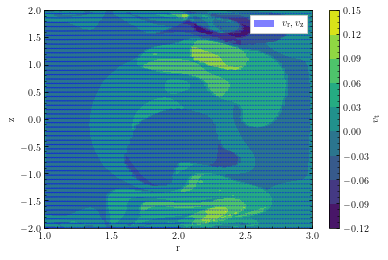

In [15]:
m = -1.2; n= 4
QV = plt.quiver(r_avg[::n], z_avg[::n], (10**m)*vr_avg[::n], (10**m)*vz_avg[::n], color='b', units='xy', scale=1, alpha=0.5)
Z = griddata((r_avg,z_avg),vt_avg,(A,B))
plt.contourf(A,B,Z, zorder=-1,); plt.colorbar(label=r"$v_{\rm t}$"); plt.xlabel("r");plt.ylabel("z");
plt.legend([QV], [r"$v_{\rm r}, v_{\rm z}$"], loc='upper right', frameon=True)
plt.savefig("/home/hlane/yt-conda/PPPL/plots/crunchTheta_Vmap.pdf",bbox_inches='tight')

### Generate delta (vr, vt) vector, vr*vz color countor map.


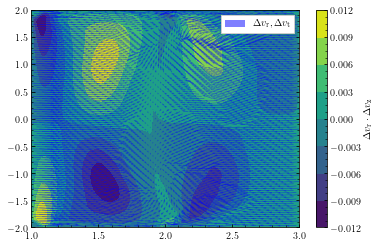

In [11]:
n=6; m=0
vt_mean = np.mean(vt_avg); delta_vt = vt_avg - vt_mean
vr_mean = np.mean(vr_avg); delta_vr = vr_avg - vr_mean
vz_mean = np.mean(vz_avg); delta_vz = vz_avg - vz_mean
QV1 = plt.quiver(r_avg[::n], z_avg[::n], (10**m)*delta_vr[::n], (10**m)*delta_vt[::n], color='b', units='xy', scale=1, alpha=0.5)
Z = griddata((r_avg,z_avg),delta_vr*delta_vz,(A,B))
plt.contourf(A,B,Z, zorder=-1); plt.colorbar(label=r"$\Delta v_{\rm r} \cdot \Delta v_{\rm z}$")
plt.legend([QV1], [r"$\Delta v_{\rm r}, \Delta v_{\rm t}$"], loc='upper right', frameon=True)
plt.savefig("/home/hlane/yt-conda/PPPL/plots/crunchTheta_deltaVmap.pdf",bbox_inches='tight')

## Generate Magnetic Induction Grid and Graphs

In [16]:
filename = 'testsnap_B.hdf5' 
F = h5py.File(filename, "r")
Coordinates_b = np.array(F["Point"]["Positions"])
MagneticInduction = np.array(F["Cell"]["MagInduction"])
F.close()
#We load our data.

In [18]:
#Positions is a grid.
#Cubes returns the indicies of the Coordinates, which can be used to assign them to cubes. 
import numpy as np
from scipy.spatial import KDTree
CubeLength_b = 0.02
numR_b = int((Coordinates_b[:,0].max() - Coordinates_b[:,0].min())/CubeLength_b)
numT_b = int((Coordinates_b[:,1].max() - Coordinates_b[:,1].min())/CubeLength_b)
numZ_b = int((Coordinates_b[:,2].max() - Coordinates_b[:,2].min())/CubeLength_b)

r_i_b = np.linspace(Coordinates_b[:,0].min(),Coordinates_b[:,0].max(),numR_b)
t_i_b = np.linspace(Coordinates_b[:,1].min(),Coordinates_b[:,1].max(),numT_b)
z_i_b = np.linspace(Coordinates_b[:,2].min(),Coordinates_b[:,2].max(),numZ_b)

A_b, B_b, C_b = np.meshgrid(r_i_b, t_i_b, z_i_b)
positions_b = np.vstack([A_b.ravel(), B_b.ravel(), C_b.ravel()]).T
T_b = KDTree(Coordinates_b)
Cubes_b = np.array(T_b.query_ball_point(positions_b, (CubeLength_b/2), eps=0, p=np.inf, workers=8)); print(np.shape(Cubes_b))
#Returns nearest-neighbor search for cubes of volume CubeLength**3
#Steps:
#1. We created a grid with Positions. 
#2. We now need to populate Positions with the right velocities (tensors) based on the indicies given by Cubes[1].
#3. We then take the average along an axis and return with our final visualization.

(3526600,)


In [19]:
#For each defined cell of the grid positions, we take the neighbors (as found in cubes) and find
#an individual value for each and every grid position. This should return an array with a unique value
#for grid position of a velocity. Then, we can easily find the averages along an axis
def MagAverage(neighbors_b):
    MagList = []
    for n in neighbors_b:
        MagList.append(np.average(MagneticInduction[n],axis = 0))
    return MagList    
MagFinal = np.array(MagAverage(Cubes_b))
print(np.shape(MagFinal))
print(np.shape(positions_b))

/home/hlane/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/hlane/.local/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(3526600, 3)
(3526600, 3)


In [20]:
r_i = np.linspace(Coordinates_b[:,0].min(),Coordinates_b[:,0].max(),100)
z_i = np.linspace(Coordinates_b[:,2].min(),Coordinates_b[:,2].max(),200)
A, B = np.meshgrid(r_i,z_i)
GridFinal_b = np.concatenate((positions_b, MagFinal),axis=1)
#New approach. Create slices from data.
arrTheta_b = np.empty((numR_b*numZ_b, len(GridFinal_b[1])))
for t in np.unique(GridFinal_b[:,1]):
    id1 = GridFinal_b[:,1]==t
    slice = GridFinal_b[id1]
    arrTheta_b = np.dstack([arrTheta_b, slice])
    #break
arrTheta_b = arrTheta_b[:,:,1:] #Excludes the empty array we created.
#We now crunch theta across the theta axis.
crunchTheta_b = np.nanmean(arrTheta_b, axis=2)
r_avg_b = crunchTheta_b[:,0]
t_avg_b = crunchTheta_b[:,1]
z_avg_b = crunchTheta_b[:,2]
Br_avg = crunchTheta_b[:,3]
Bt_avg = crunchTheta_b[:,4]
Bz_avg = crunchTheta_b[:,5]
print(arrTheta_b.shape)

(22900, 6, 154)


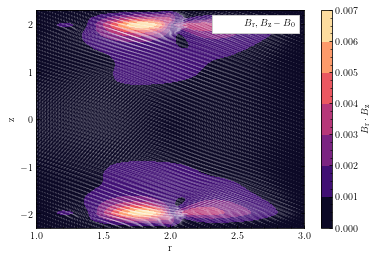

In [21]:
Bz_0 = 0.2; n = 4; m=1.2
QV2 = plt.quiver(r_avg_b[::n], z_avg_b[::n], (10**m)*Br_avg[::n], (10**m)*(Bz_avg[::n]-Bz_0), color='white', units='xy', scale=1, alpha=0.3)
Zb = griddata((r_avg_b,z_avg_b),Br_avg*Bz_avg,(A,B))
plt.contourf(A,B,Zb, zorder=-1, cmap = 'magma'); plt.colorbar(label=r"$B_{\rm r} \cdot B_{\rm z}$"); plt.xlabel("r");plt.ylabel("z");
plt.legend([QV2], [r"$B_{\rm r}, B_{\rm z} - B_{\rm 0}$"], loc='upper right', frameon=True)
#plt.tick_params(axis='x', colors='white')    
#plt.tick_params(axis='y', colors='white')
plt.savefig("/home/hlane/yt-conda/PPPL/plots/crunchTheta_Bmap.pdf.pdf",bbox_inches='tight')

In [ ]:
print(np.mean(Bz_avg))

In [ ]:
__class__         __gt__             __reduce__         cell_data_dict     info
__delattr__       __hash__           __reduce_ex__      cell_sets          int_data_to_sets
__dict__          __init__           __repr__           cell_sets_dict     point_data
__dir__           __init_subclass__  __setattr__        cells              point_sets
__doc__           __le__             __sizeof__         cells_dict         points
__eq__            __lt__             __str__            field_data         prune
__format__        __module__         __subclasshook__   get_cell_data      read
__ge__            __ne__             __weakref__        get_cells_type     sets_to_int_data
__getattribute__  __new__            cell_data          gmsh_periodic      write